# Final Task: Project Based Internship Home Credit Indonesia x Rakamin Academy (Home Credit Scorecard Model)

By Wika Rabila Putri (DS 41 & JAP 28)

**Project Background**

Home Credit Indonesia is dedicated to enhancing its credit scoring system, ensuring that deserving customers have access to the loans they need. Currently, the company employs various statistical methods and Machine Learning techniques to predict credit scores. Despite these efforts, there is still considerable untapped potential within the available data. By optimizing data utilization, Home Credit aims to create a more accurate and fair assessment process, reducing the likelihood of capable borrowers being unjustly denied loans.

This project focuses on developing an improved credit scorecard model that not only evaluates customer creditworthiness effectively but also tailors loan structures to promote successful repayments. With the right approach, Home Credit can better serve its customers while mitigating risk.

**Problem**

Home Credit faces challenges in accurately assessing credit risk, leading to the rejection of customers who are financially capable of repaying loans. Current models may not fully capture all relevant factors, resulting in missed opportunities for lending and potential customer dissatisfaction.

**Goals**

Develop a more precise credit scoring model using Machine Learning techniques, create a reliable scorecard that improves loan performance, enhances customer satisfaction, and supports responsible lending practices.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Data Understanding

In [2]:
#import dataset

df = pd.read_csv(r'C:\Users\Wika Rabila Putri\Documents\Documents Lenovo\Rakamin\JAP\PBI September Home Credit Indonesia\Dataset HCI\application_train.csv')
df.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
217494,352006,0,Cash loans,F,N,Y,0,261000.0,490500.0,33039.0,...,0,0,0,0,0.0,0.0,0.0,1.0,2.0,5.0
284388,429346,0,Cash loans,M,Y,N,1,157500.0,348264.0,41458.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
299908,447439,0,Cash loans,M,N,Y,0,112500.0,521280.0,28408.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
149268,273059,1,Cash loans,F,N,Y,0,202500.0,123637.5,11340.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
51176,159260,0,Cash loans,M,Y,Y,1,337500.0,1506816.0,49927.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [4]:
# Checking numeric columns
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
print(f"Total numeric columns: {numerical_columns.shape[1]}")

# Checking categorical columns
categorical_columns = df.select_dtypes(include=['object', 'category'])
print(f"Total categorical columns: {categorical_columns.shape[1]}")

Total numeric columns: 106
Total categorical columns: 16


### The Number of Customers Who Apply For Loans

In [5]:
total_cust = df.groupby('TARGET')['CODE_GENDER'].count().reset_index()
total_cust.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

total_cust['Customers_%'] = round(total_cust.Customers / total_cust.Customers.sum(), 2)
total_cust

,TARGET,Customers,Customers_%
0,0,282686,0.92
1,1,24825,0.08


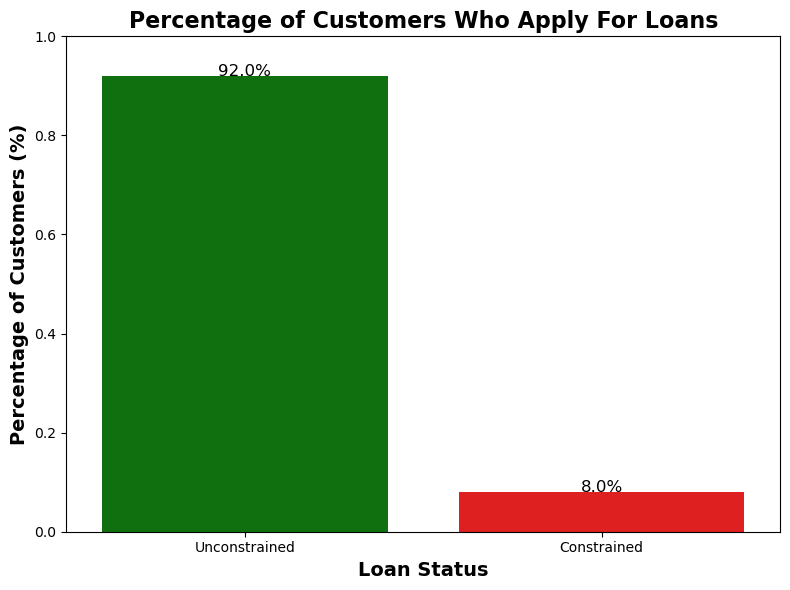

In [6]:
# Mapping TARGET values to labels
total_cust['Status'] = total_cust['TARGET'].map({0: 'Unconstrained', 1: 'Constrained'})

# Create the bar plot for percentages
plt.figure(figsize=(8, 6))
sns.barplot(x='Status', y='Customers_%', data=total_cust, palette=['green', 'red'])

# Add data labels on top of the bars
for index, row in total_cust.iterrows():
    plt.text(index, row['Customers_%'], f"{row['Customers_%']*100:.1f}%", color='black', ha="center", fontsize=12)

plt.title('Percentage of Customers Who Apply For Loans', fontsize=16, fontweight='bold')
plt.xlabel('Loan Status', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Customers (%)', fontsize=14, fontweight='bold')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

Based on the table, **92%** of customers managed to repay their loans on time, while **8%** encountered difficulties. This notable discrepancy leads us to investigate the factors that set these two groups apart, specifically the characteristics that contribute to timely loan repayment.

### Marital Status of Customers

In [7]:
df.NAME_FAMILY_STATUS.value_counts()

NAME_FAMILY_STATUS
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64

Based on the table, we can streamline the six marital categories into two clear groups: married and unmarried.
- married = have a partner
- unmarried = not have a partner or have had a partner

In [8]:
Marital_status = []
married = ['Married', 'Civil marriage']

for i in df.NAME_FAMILY_STATUS:
    if i in married:
        Marital_status.append('Married')
    else:
        Marital_status.append('Unmarried')

df['Marital_status'] = Marital_status
df.drop(columns= 'NAME_FAMILY_STATUS', inplace=True)

In [9]:
ms_new = df[df['TARGET'] == 0].groupby(['Marital_status'])['CODE_GENDER'].count().reset_index()
ms_new.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

ms_new['Customers_%'] = round(total_cust.Customers / total_cust.Customers.sum(), 2)
ms_new

,Marital_status,Customers,Customers_%
0,Married,208396,0.92
1,Unmarried,74290,0.08


**92%** of customers who successfully repaid their loans on time were **married**.

In [10]:
ms_new2 = df.groupby(['Marital_status', 'TARGET'])['CODE_GENDER'].count().reset_index()
ms_new2.rename(columns={'CODE_GENDER': 'Customers'}, inplace=True)

ms_new2 ['Customers_%'] = round(ms_new2.Customers / ms_new2.Customers.sum(), 2)
mapping_target = {
    1 : 'Constrained', #for customers with repayment issues
    0 : 'Unconstrained' #for customers without repayment issues
}

ms_new2['TARGET'] = ms_new2['TARGET'].map(mapping_target)
ms_new2

,Marital_status,TARGET,Customers,Customers_%
0,Married,Unconstrained,208396,0.68
1,Married,Constrained,17811,0.06
2,Unmarried,Unconstrained,74290,0.24
3,Unmarried,Constrained,7014,0.02


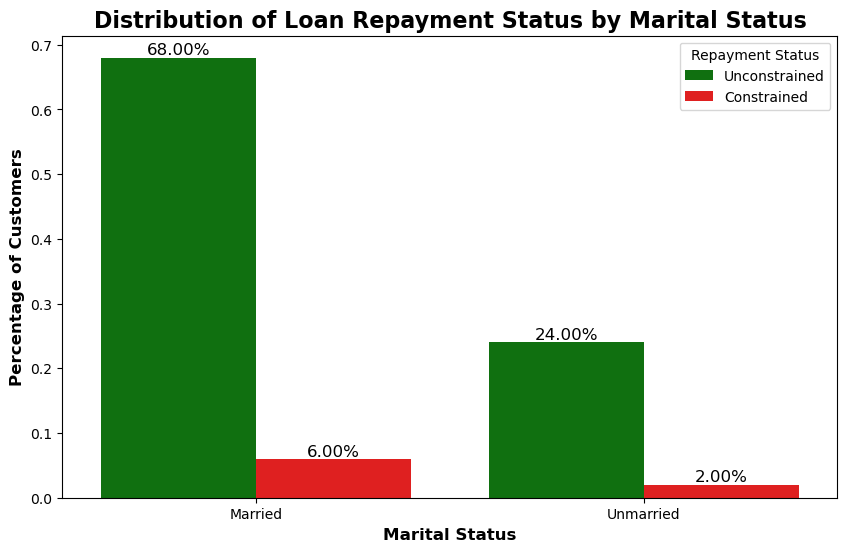

In [11]:
plt.figure(figsize=(10, 6))

colors = {'Unconstrained': 'green', 'Constrained': 'red'}
sns.barplot(x='Marital_status', y='Customers_%', hue='TARGET', data=ms_new2, palette=colors)

plt.title('Distribution of Loan Repayment Status by Marital Status', fontsize=16, fontweight='bold')
plt.xlabel('Marital Status', fontsize=12, fontweight='bold')
plt.ylabel('Percentage of Customers', fontsize=12, fontweight='bold')

# Display percentage values on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', fontsize=12)

plt.legend(title='Repayment Status', loc='upper right')
plt.show()

- Married individuals show a higher rate of successful loan repayment (68%) compared to unmarried individuals (24%). 
- Meanwhile, the proportion of constrained (defaulting or struggling) customers is relatively low, with married individuals at 6% and unmarried individuals at only 2%. 

This suggests that being married may be associated with more reliable loan repayment behavior.

### Age of Customers

Since there is no column for customer age, we will create it using the **DAYS_BIRTH** column, which contains the data representing the difference in days between today and the customer's birthday.

In [12]:
df['Age'] = np.floor(df['DAYS_BIRTH'] / -365).astype(int)
df.drop(columns= 'DAYS_BIRTH', inplace=True)

In [13]:
# Age Category
# Young Adult = 20 - 35
# Adult = 35 - 50
# Older > 50
# ------------------------------------------------------------------------------
age_category = []
for i in df['Age']:
    if i < 36:
        age_category.append('Young Adult')
    elif i < 51:
        age_category.append('Adult')
    else:
        age_category.append('Older')

df['Age_Category'] = age_category

In [14]:
category_age = df.groupby(['Age_Category','TARGET'])['CODE_GENDER'].count().reset_index().sort_values('Age_Category').reset_index()
category_age.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
category_age.drop(columns = 'index', inplace=True)

name_of_ot = list(category_age['Age_Category'].unique())
percentage = []

for i in name_of_ot:
    data = category_age[category_age['Age_Category'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

category_age['percentage'] = percentage

mapping_target = {
    1 : 'Constrained', #for customers with repayment issues
    0 : 'Unconstrained' #for customers without repayment issues
}

category_age['TARGET'] = category_age['TARGET'].map(mapping_target)
category_age

,Age_Category,TARGET,Customers,percentage
0,Adult,Unconstrained,108678,0.92
1,Adult,Constrained,9403,0.08
2,Older,Unconstrained,91718,0.94
3,Older,Constrained,5469,0.06
4,Young Adult,Unconstrained,82290,0.89
5,Young Adult,Constrained,9953,0.11


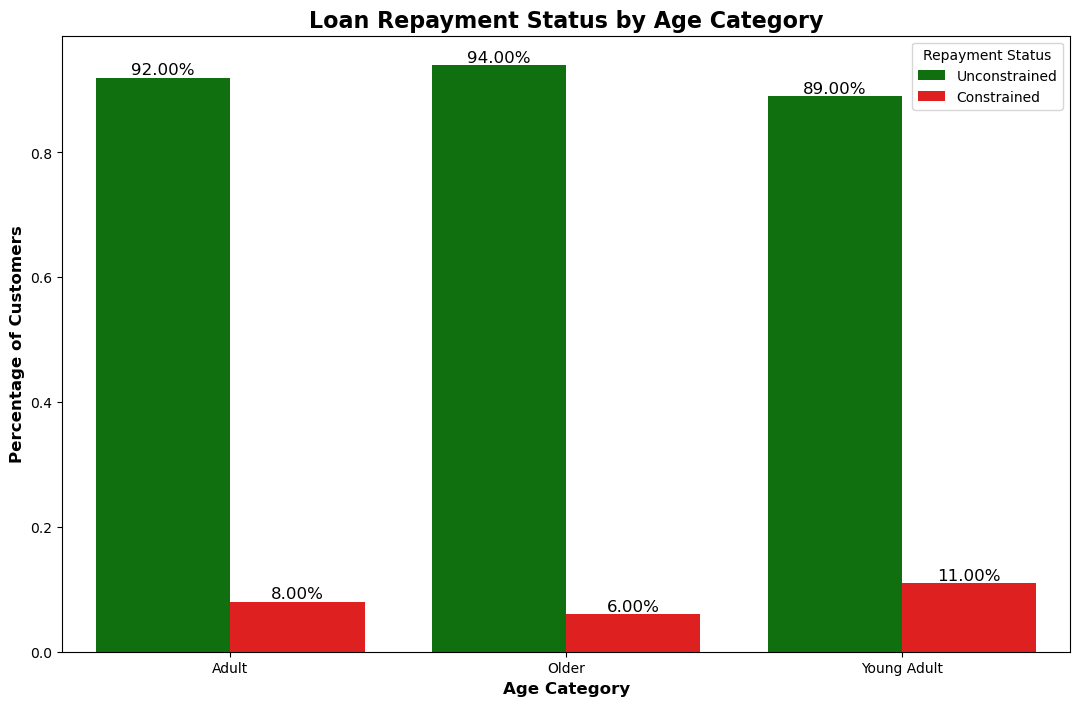

In [15]:
plt.figure(figsize=(13, 8))
colors = {'Unconstrained': 'green', 'Constrained': 'red'}

sns.barplot(x='Age_Category', y='percentage', hue='TARGET', data=category_age, palette=colors)
plt.title('Loan Repayment Status by Age Category', fontsize=16, fontweight='bold')
plt.xlabel('Age Category', fontsize=12, fontweight='bold')
plt.ylabel('Percentage of Customers', fontsize=12, fontweight='bold')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', fontsize=12)

# Show the plot
plt.legend(title='Repayment Status', loc='upper right')
plt.show()

- **92% of the adult** category falls under the **Unconstrained** group, indicating that they successfully repay their loans on time.
- **94% of older** customers are categorized as **Unconstrained**, highlighting their reliability in loan repayment.
- Although **89% of young adults** are in the **Unconstrained** group, **11%** experience repayment issues. This suggests a need for additional support or financial education for this age group.

### Income Type of Customers

In [16]:
income_cust = df.groupby(['TARGET', 'NAME_INCOME_TYPE', 'NAME_CONTRACT_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(['NAME_INCOME_TYPE', 'NAME_CONTRACT_TYPE']).reset_index()
income_cust.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
income_cust.drop(columns = 'index', inplace=True)

income_type = list(income_cust['NAME_INCOME_TYPE'].unique())
percentage = []

for i in income_type:
    data = income_cust[income_cust.NAME_INCOME_TYPE == i]
    contract_type = list(data['NAME_CONTRACT_TYPE'].unique())
    for x in contract_type:
        data2 = data[data.NAME_CONTRACT_TYPE == x]
        total = data2['Customers'].sum()
        for y,z in enumerate(data2['Customers']):
            pct = round(z / total, 2)
            percentage.append(pct)
            
income_cust['percentage'] = percentage
income_cust

,TARGET,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,Customers,percentage
0,0,Businessman,Revolving loans,10,1.00
1,0,Commercial associate,Cash loans,58662,0.92
2,1,Commercial associate,Cash loans,4990,0.08
3,0,Commercial associate,Revolving loans,7595,0.95
4,1,Commercial associate,Revolving loans,370,0.05
5,1,Maternity leave,Cash loans,2,1.00
6,0,Maternity leave,Revolving loans,3,1.00
7,0,Pensioner,Cash loans,49151,0.95
8,1,Pensioner,Cash loans,2842,0.05
9,0,Pensioner,Revolving loans,3229,0.96


In [17]:
income_type_cust = df[['NAME_INCOME_TYPE','TARGET']].groupby(['NAME_INCOME_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)
income_type_cust

,NAME_INCOME_TYPE,TARGET
2,Maternity leave,0.400000
6,Unemployed,0.363636
7,Working,0.095885
1,Commercial associate,0.074843
4,State servant,0.057550
3,Pensioner,0.053864
0,Businessman,0.000000
5,Student,0.000000


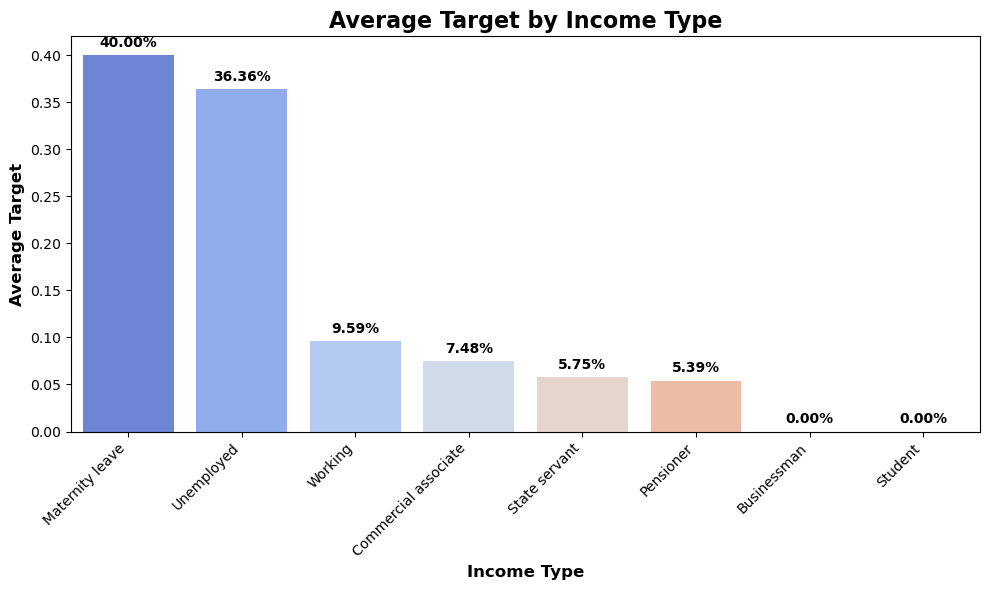

In [18]:
plt.figure(figsize=(10,6))
sns.barplot(x='NAME_INCOME_TYPE', y='TARGET', data=income_type_cust, palette='coolwarm')


plt.title('Average Target by Income Type', fontsize=16, fontweight='bold')
plt.xlabel('Income Type', fontsize=12, fontweight='bold')
plt.ylabel('Average Target', fontsize=12, fontweight='bold')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height() * 100:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=10, color='black', fontweight='bold')


plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Clients with **Maternity leave** and **Unemployed** income types have the highest risk of repayment issues, with TARGET percentages of **40%** and **36%**, indicating they struggle the most with timely loan repayments compared to other income types.

### Contract Type of Customers

In [19]:
con_type = df.groupby(['TARGET', 'NAME_CONTRACT_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(by = 'NAME_CONTRACT_TYPE')
con_type.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
        
name_of_contype = list(con_type['NAME_CONTRACT_TYPE'].unique())
percentage = []

for i in name_of_contype:
    data = con_type[con_type['NAME_CONTRACT_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)
        
con_type['Percent'] = percentage
con_type['Percent All'] = round(con_type['Customers'] / total, 2)
mapping_target = {
    1 : 'Constrained', #for customers with repayment issues
    0 : 'Unconstrained' #for customers without repayment issues
}

con_type['TARGET'] = con_type['TARGET'].map(mapping_target)
con_type

,TARGET,NAME_CONTRACT_TYPE,Customers,Percent,Percent All
0,Unconstrained,Cash loans,255011,0.92,8.71
2,Constrained,Cash loans,23221,0.08,0.79
1,Unconstrained,Revolving loans,27675,0.95,0.95
3,Constrained,Revolving loans,1604,0.05,0.05


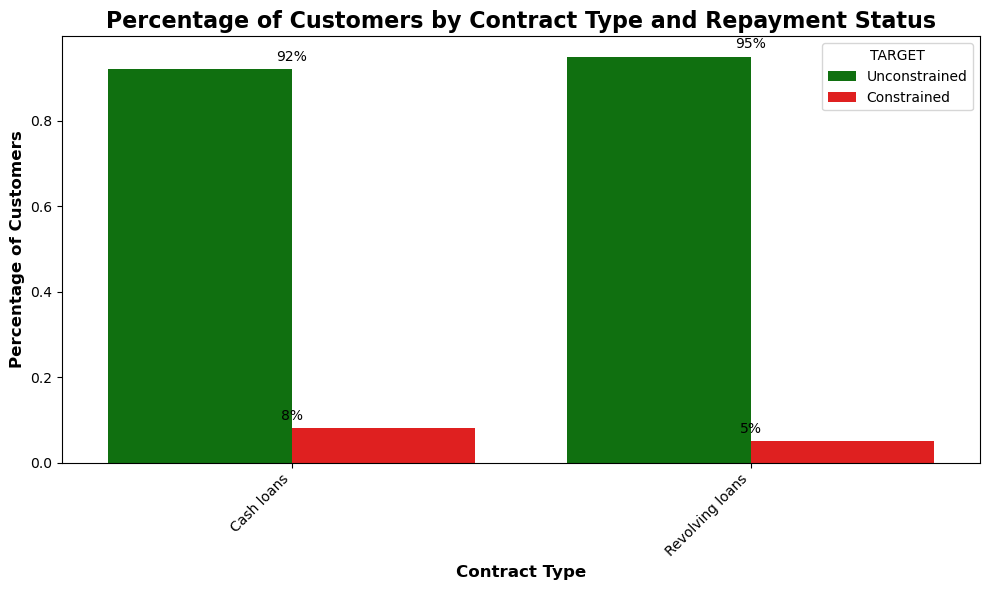

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x='NAME_CONTRACT_TYPE', y='Percent', hue='TARGET', data=con_type, palette={'Unconstrained':'green', 'Constrained':'red'})

plt.title('Percentage of Customers by Contract Type and Repayment Status', fontsize=16, fontweight='bold')
plt.xlabel('Contract Type', fontsize=12, fontweight='bold')
plt.ylabel('Percentage of Customers', fontsize=12, fontweight='bold')

for index, row in con_type.iterrows():
    plt.text(index % 2, row.Percent + 0.02, f"{row.Percent * 100:.0f}%", color='black', ha="center", fontsize=10)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

There is no significant difference in the contract type regarding repayment issues. While **Cash Loans** are the preferred choice among customers, the percentage of repayment problems is similar for both cash loans and revolving loans.

### Occupation Type of Customers

In [21]:
occupation_type = df.groupby([ 'OCCUPATION_TYPE','TARGET'])['CODE_GENDER'].count().reset_index().sort_values(by = 'OCCUPATION_TYPE')
occupation_type.rename(columns = {'CODE_GENDER' : 'Customers Count'}, inplace=True)

name_occupation_type = list(occupation_type['OCCUPATION_TYPE'].unique())
percentage = []

for i in name_occupation_type:
    data = occupation_type[occupation_type['OCCUPATION_TYPE'] == i]
    total = data['Customers Count'].sum()
    for x,y in enumerate(data['Customers Count']):
        pct = round(y / total, 2)
        percentage.append(pct)

occupation_type['Percent'] = percentage
occupation_type['Percent All'] = round(occupation_type['Customers Count'] / total, 2)

mapping_target = {
    1 : 'Constrained', #for customers with repayment issues
    0 : 'Unconstrained' #for customers without repayment issues
}

occupation_type['TARGET'] = occupation_type['TARGET'].map(mapping_target)
occupation_type

,OCCUPATION_TYPE,TARGET,Customers Count,Percent,Percent All
0,Accountants,Unconstrained,9339,0.95,6.93
1,Accountants,Constrained,474,0.05,0.35
2,Cleaning staff,Unconstrained,4206,0.90,3.12
3,Cleaning staff,Constrained,447,0.10,0.33
4,Cooking staff,Unconstrained,5325,0.90,3.95
5,Cooking staff,Constrained,621,0.10,0.46
6,Core staff,Unconstrained,25832,0.94,19.16
7,Core staff,Constrained,1738,0.06,1.29
8,Drivers,Unconstrained,16496,0.89,12.24
9,Drivers,Constrained,2107,0.11,1.56


In [22]:
occupation_type.sort_values('Percent', ascending=False).head(6)

,OCCUPATION_TYPE,TARGET,Customers Count,Percent,Percent All
0,Accountants,Unconstrained,9339,0.95,6.93
6,Core staff,Unconstrained,25832,0.94,19.16
14,IT staff,Unconstrained,492,0.94,0.36
12,High skill tech staff,Unconstrained,10679,0.94,7.92
10,HR staff,Unconstrained,527,0.94,0.39
20,Managers,Unconstrained,20043,0.94,14.87


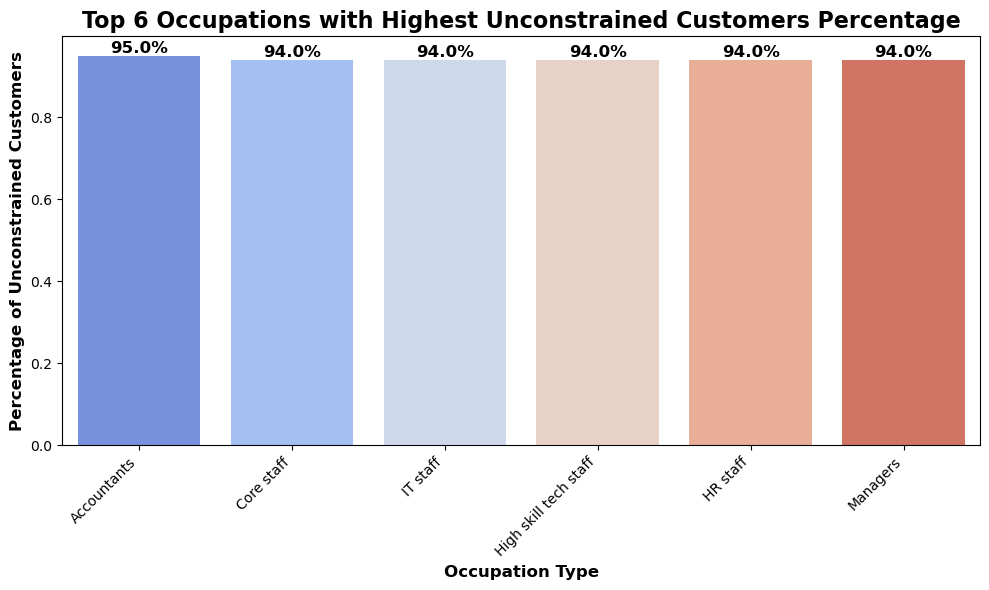

In [23]:
# Top 6 occupations with highest unconstrained percentages (94% or above)
top_occupations = occupation_type.sort_values('Percent', ascending=False).head(6)

plt.figure(figsize=(10, 6))
sns.barplot(x='OCCUPATION_TYPE', y='Percent', data=top_occupations, palette='coolwarm')

for index, value in enumerate(top_occupations['Percent']):
    plt.text(index, value, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Top 6 Occupations with Highest Unconstrained Customers Percentage', fontsize=16, fontweight='bold')
plt.xlabel('Occupation Type', fontsize=12, fontweight='bold')
plt.ylabel('Percentage of Unconstrained Customers', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Occupations such as **Accountants, Core Staff, IT Staff, High-skill tech staff, HR Staff, and Managers** show a high percentage of **Unconstrained** customers (94% or above), meaning most individuals in these roles do not face issues repaying loans.
- **Laborers, Drivers, Sales staff, and Cleaning staff** have a relatively higher proportion of **Constrained** customers, ranging from **10% to 11%**. Notably, **Low-skill laborers** show a **Constrained** rate of **17%**, indicating financial instability.
- **Recommendation:** Lenders could consider stricter credit evaluations and tailored financial products for high-risk occupations such as laborers and drivers, as well as providing targeted financial education.

## Data Cleaning

### Checking duplicate

In [24]:
num_duplicates = df.duplicated().sum()
print(f'Total duplicate data: {num_duplicates}')

Total duplicate data: 0


### Check missing values

In [25]:
num_missing_columns = (df.isnull().sum() > 0).sum()

print(f"Total columns that have missing values: {num_missing_columns}")

Total columns that have missing values: 67


In [26]:
missing_values = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()
missing_values['Percentage'] = ( missing_values['Total Null Data'] / len(df) ) * 100
missing_values[missing_values['Percentage'] > 40].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage
46,COMMONAREA_AVG,214865,69.872297
74,COMMONAREA_MEDI,214865,69.872297
60,COMMONAREA_MODE,214865,69.872297
82,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
68,NONLIVINGAPARTMENTS_MODE,213514,69.432963
54,NONLIVINGAPARTMENTS_AVG,213514,69.432963
84,FONDKAPREMONT_MODE,210295,68.386172
80,LIVINGAPARTMENTS_MEDI,210199,68.354953
52,LIVINGAPARTMENTS_AVG,210199,68.354953
66,LIVINGAPARTMENTS_MODE,210199,68.354953


Features with **more than 40%** missing data are removed to avoid unreliable imputation, reduce bias, and improve model performance by maintaining data quality and simplicity.

In [27]:
data = list(missing_values[missing_values['Percentage'] > 40]['index'])
df = df.drop(columns = data)
df = df.drop(columns = 'SK_ID_CURR')

In [28]:
missing_values = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()
missing_values['Percentage'] = (missing_values['Total Null Data'] / len(df) ) * 100
data_null = missing_values[missing_values['Percentage'] != 0].sort_values(by='Percentage', ascending=False)

In [29]:
a = list(data_null['index'])
df[a].dtypes

for i in a:
    data = df[i]
    types = str(data.dtype)
    if types == 'object':
        df[i].fillna(df[i].mode()[0], inplace=True)
    else:
        df[i].fillna(df[i].median(), inplace=True)

In [30]:
# Re-check missing values

missing_values = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()
missing_values['Percentage'] = (missing_values['Total Null Data'] / len(df) ) * 100
missing_values[missing_values['Percentage'] > 0].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage


### Impute missing values

In [31]:
df['CODE_GENDER'] = df['CODE_GENDER'].replace(['XNA'], df['CODE_GENDER'].mode()[0])
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(['XNA'], df['ORGANIZATION_TYPE'].mode()[0])

In [32]:
# Remove FLAG_DOCUMENT column

FLAG_DOCUMENT = [col for col in df.columns if 'FLAG_DOCUMENT' in col]
df.drop(columns = FLAG_DOCUMENT, axis=1, inplace=True)

## Feature Engineering

In [33]:
x = df.drop(columns = 'TARGET')

### Numberic

In [34]:
num = x.select_dtypes(exclude='object')
num.sample(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
19562,0,85500.0,247500.0,12375.0,247500.0,0.015221,-4402,-2954.0,-3989,1,...,2.0,0.0,-1028.0,0.0,0.0,0.0,2.0,0.0,1.0,41
199552,0,90000.0,1494486.0,41094.0,1305000.0,0.006008,365243,-8105.0,-4095,1,...,0.0,0.0,-1546.0,0.0,0.0,0.0,0.0,0.0,0.0,61
222070,1,270000.0,835380.0,40320.0,675000.0,0.032561,-1300,-8993.0,-177,1,...,7.0,0.0,-2450.0,0.0,0.0,0.0,0.0,0.0,2.0,45
63022,1,180000.0,310734.0,30861.0,274500.0,0.018850,-2533,-2567.0,-3864,1,...,0.0,0.0,-1741.0,0.0,0.0,0.0,1.0,0.0,4.0,35
43833,0,139500.0,337500.0,16875.0,337500.0,0.020246,-1056,-4205.0,-4131,1,...,0.0,0.0,-515.0,0.0,0.0,0.0,1.0,0.0,2.0,57


In [35]:
# Absolute

negative_column = num.columns[(num < 0).any()].tolist()
num[negative_column] = num[negative_column] * -1
num.sample(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
68954,0,54000.0,135000.0,6750.0,135000.0,0.024610,1229,7427.0,419,1,...,0.0,0.0,118.0,0.0,0.0,0.0,0.0,0.0,1.0,46
240027,0,270000.0,966555.0,51628.5,913500.0,0.035792,2722,2985.0,3628,1,...,0.0,0.0,-0.0,0.0,0.0,0.0,1.0,0.0,3.0,55
93577,0,135000.0,360000.0,18000.0,360000.0,0.022625,-365243,619.0,1899,1,...,0.0,0.0,800.0,0.0,0.0,0.0,0.0,1.0,3.0,54
198697,0,135000.0,242595.0,18904.5,202500.0,0.007305,577,3364.0,3365,1,...,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
27774,0,270000.0,675000.0,19867.5,675000.0,0.014464,4598,3205.0,1429,1,...,0.0,0.0,161.0,0.0,0.0,0.0,0.0,0.0,2.0,48


In [36]:
# Filter numeric columns with > 2 unique values

df_num = pd.DataFrame(num.nunique(), columns = ['Total_unique']).reset_index()
df_num = df_num.rename(columns = {'index' : 'Name_of_column'})

num_a = []
num_b = []
for i,y in enumerate(df_num.Name_of_column):
    if df_num['Total_unique'][i] > 2:
        num_a.append(y)
    else:
        num_b.append(y)

#### Data Distribution

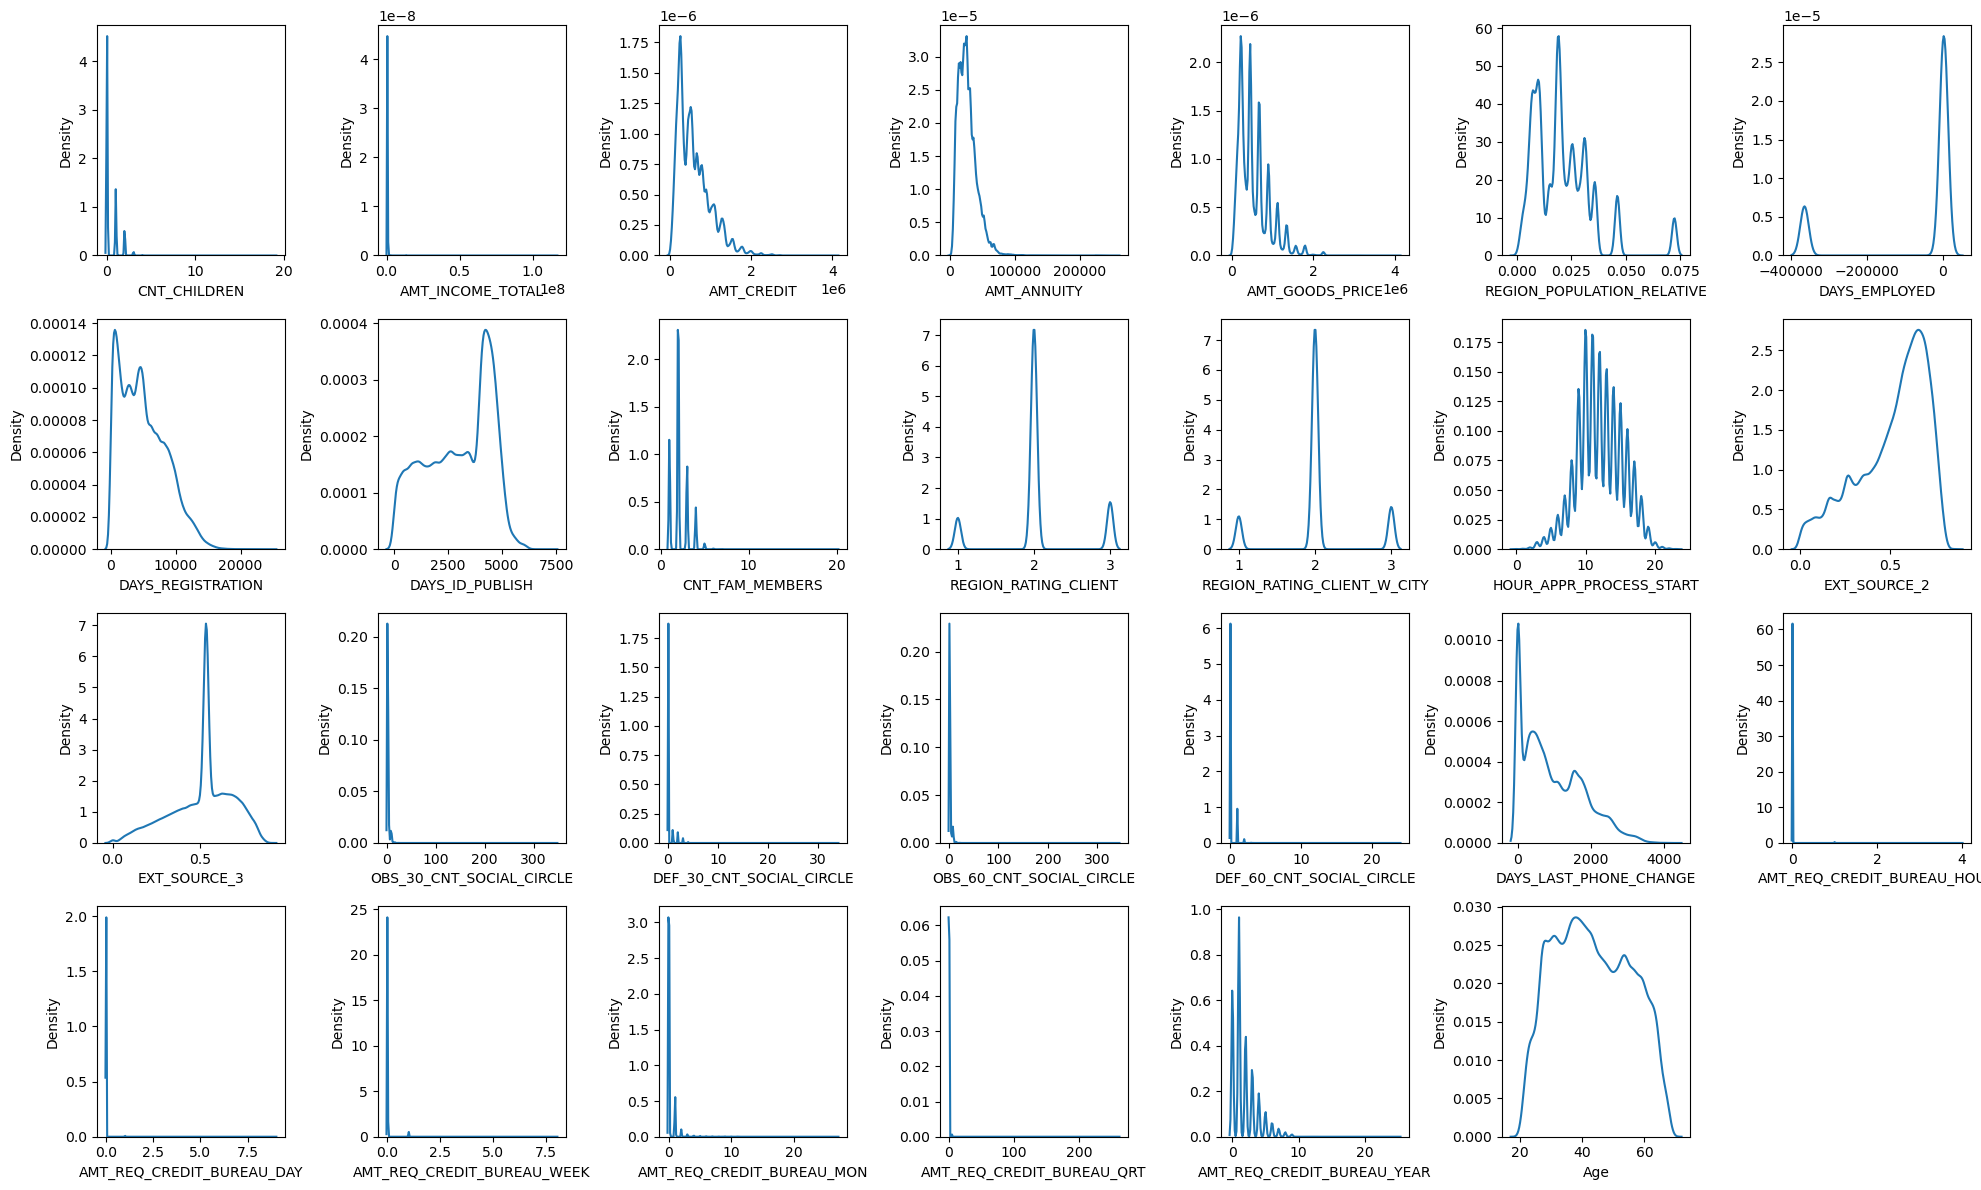

In [37]:
plt.figure(figsize=(20,12))

for i, column in enumerate(num[num_a].columns, 1):
    plt.subplot(4,7,i)
    sns.kdeplot(data=num[num_a], x=column)
    
plt.tight_layout()
plt.show()

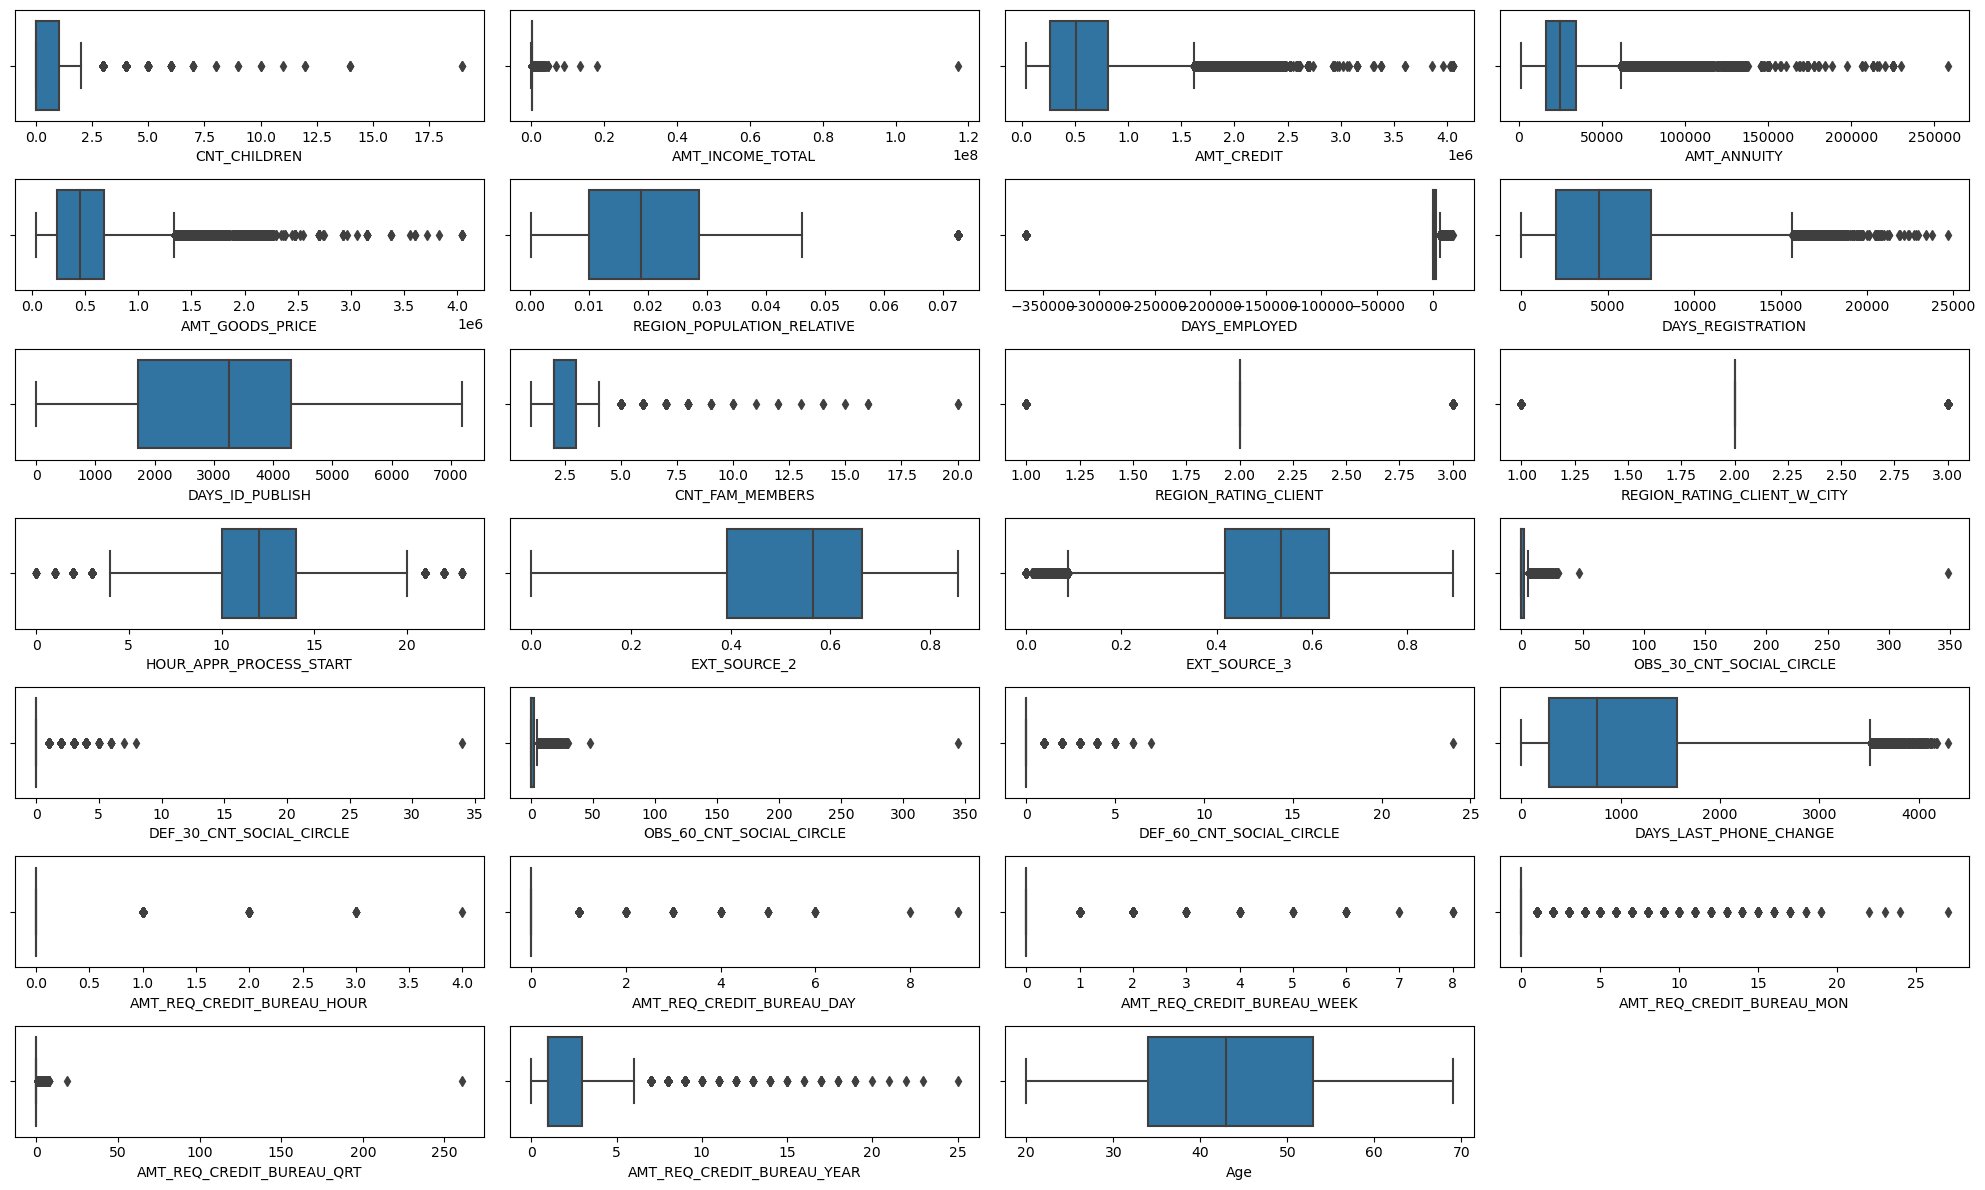

In [38]:
plt.figure(figsize=(20,12))

for i, column in enumerate (num[num_a].columns, 1):
    plt.subplot(7,4,i)
    sns.boxplot(data=num[num_a], x=num[column])

plt.tight_layout()
plt.show()

In [39]:
# Remove outlier

print(f'Row before delete outlier at CNT_children :  {len(df)}')

filtered_entries = np.array([True] * len(df))
zscore = abs(stats.zscore(df['CNT_CHILDREN']))
filtered_entries = (zscore < 3) & filtered_entries
    
df = df[filtered_entries]
print(f'Row after delete outlier at CNT_children : {len(df)}')

Row before delete outlier at CNT_children :  307511
Row after delete outlier at CNT_children : 303239


#### Feature Transformation

In [40]:
x = df.drop(columns = 'TARGET', axis=1)
num = x[num_a]

In [41]:
num_mean = num.mean()
num_std = num.std()

num = (num - num_mean) / num_std
num.sample(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
212641,-0.589198,-0.292491,-1.264236,-1.491157,-1.213589,0.754796,-0.456589,-1.503747,0.945736,-1.320962,...,-0.588676,-0.275683,0.444181,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,1.257036,0.456336
266321,-0.589198,-0.235866,-0.928869,-0.994522,-0.848093,-1.030581,-0.480021,1.055559,-1.095884,-1.320962,...,1.514425,-0.275683,1.164645,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,0.124965,1.873719
305954,-0.589198,-0.481239,-0.187841,-0.856533,-0.336399,0.309175,2.118014,0.656216,-2.024255,-1.320962,...,-0.588676,-0.275683,-0.678826,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-0.441070,1.623592
31267,-0.589198,0.141631,2.352814,1.259605,2.197705,1.077392,-0.457744,1.261607,-0.308658,-0.131831,...,0.252564,-0.275683,1.164645,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,0.124965,0.873213
20920,-0.589198,-0.141492,0.321829,1.215474,0.370226,0.843848,2.118014,-2.025811,-0.736066,-0.131831,...,0.252564,-0.275683,-0.543436,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,0.124965,1.540217


In [42]:
num_1 = x[num_b]
num_1 = num_1.loc[~num_1.index.duplicated(keep='first')]

num = pd.concat([num, num_1], axis=1)
num

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
0,-0.589198,0.141631,-0.477744,-0.165346,-0.506964,-0.150759,-0.459710,0.385831,0.577304,-1.320962,...,0,1,1,0,0,0,0,0,0,0
1,-0.589198,0.424753,1.725509,0.594213,1.600729,-1.253789,-0.463592,1.083617,1.789288,-0.131831,...,0,1,1,0,0,0,0,0,0,0
2,-0.589198,-0.424615,-1.152447,-1.405069,-1.091757,-0.784603,-0.456807,0.212377,0.304955,-1.320962,...,1,1,1,0,0,0,0,0,0,0
3,-0.589198,-0.141492,-0.711048,0.179004,-0.653162,-0.930108,-0.476632,-1.367137,0.367244,-0.131831,...,0,1,0,0,0,0,0,0,0,0
4,-0.589198,-0.198116,-0.213418,-0.361141,-0.068369,0.562091,-0.476625,0.197922,-0.309320,-1.320962,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,-0.589198,-0.047118,-0.855088,0.032003,-0.848093,0.843848,-0.456884,-0.976864,0.668749,-1.320962,...,0,1,0,0,0,0,0,0,0,0
307507,-0.589198,-0.405740,-0.818198,-1.042382,-0.848093,0.309175,2.118014,0.176098,-0.728114,-1.320962,...,0,1,1,0,0,0,0,0,0,0
307508,-0.589198,-0.065993,0.195641,0.199205,0.126562,-1.148184,-0.511027,-0.489661,-1.430522,-1.320962,...,0,1,0,1,0,0,0,0,1,1
307509,-0.589198,0.009507,-0.568393,-0.475821,-0.592246,-1.125704,-0.488940,0.693628,1.365193,-0.131831,...,0,1,0,0,0,0,0,1,1,0


### Categorical

#### Feature Transformation

In [43]:
cat = x.select_dtypes(include='object')
df_cat = pd.DataFrame(cat.nunique(), columns = ['Total_unique']).reset_index()
df_cat = df_cat.rename(columns = {'index' : 'Name_of_column'})

cat_1 = []
cat_2 = []
for i,y in enumerate(df_cat.Name_of_column):
    if df_cat['Total_unique'][i] > 2:
        cat_1.append(y)
    else:
        cat_2.append(y)
cat

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,Marital_status,Age_Category
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,Unmarried,Young Adult
1,Cash loans,F,N,N,Family,State servant,Higher education,House / apartment,Core staff,MONDAY,School,Married,Adult
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,MONDAY,Government,Unmarried,Older
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,Married,Older
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Core staff,THURSDAY,Religion,Unmarried,Older
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,With parents,Sales staff,THURSDAY,Services,Unmarried,Young Adult
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,House / apartment,Laborers,MONDAY,Business Entity Type 3,Unmarried,Older
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,House / apartment,Managers,THURSDAY,School,Unmarried,Adult
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,Married,Young Adult


### One hot Encoding

In [44]:
for cats in cat_1:
    onehots = pd.get_dummies(cat[cats], prefix=cats)
    cat = cat.join(onehots)
    
cat = cat.drop(columns = cat_1)

### Label Encoding

In [45]:
label_enc = LabelEncoder()

for cats in cat_2:
    cat[cats] = label_enc.fit_transform(cat[cats])

# Convert boolean values (False/True) to integers (0/1)
cat = cat.astype({col: int for col in cat.columns if cat[col].dtype == 'bool'})
cat

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,Marital_status,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,Age_Category_Adult,Age_Category_Older,Age_Category_Young Adult
0,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
307507,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
307508,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
307509,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [46]:
df_train = pd.concat([num, cat], axis=1)

In [47]:
df = pd.concat([df_train, df['TARGET']],axis=1)

### Data Splitting

In [48]:
x = df.drop(columns = 'TARGET')
y = df['TARGET']

### SMOTE (Oversampling)

In [49]:
smote = SMOTE(random_state = 2)
x_over, y_over = smote.fit_resample(x, y.ravel())

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.3, random_state=42)

### Random Undersampling

In [51]:
random_us = RandomUnderSampler(random_state=42)
x_under, y_under = random_us.fit_resample(x, y.ravel())

In [52]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_under, y_under, test_size=0.3, random_state=42)

## Train Logistic Regression Model

In [53]:
## with oversampling data

def confusionmatrix(predictions, y_test):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    return disp.plot()

D:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.90      0.99      0.94     83391
           1       0.99      0.88      0.94     83915

    accuracy                           0.94    167306
   macro avg       0.95      0.94      0.94    167306
weighted avg       0.95      0.94      0.94    167306



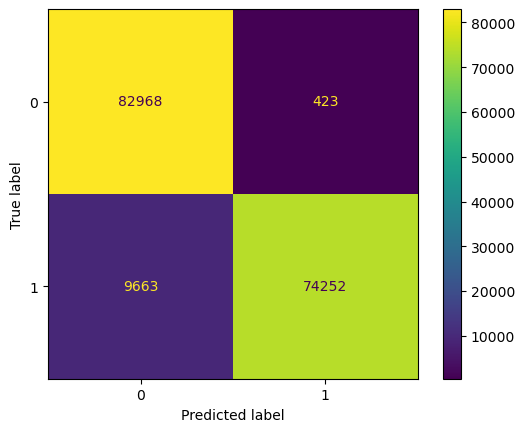

In [54]:
logreg1 = LogisticRegression()
logreg1.fit(x_train, y_train.ravel())
predictions = logreg1.predict(x_test)
  
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test)

              precision    recall  f1-score   support

           0       0.90      1.00      0.94    195452
           1       0.99      0.88      0.94    194928

    accuracy                           0.94    390380
   macro avg       0.95      0.94      0.94    390380
weighted avg       0.95      0.94      0.94    390380



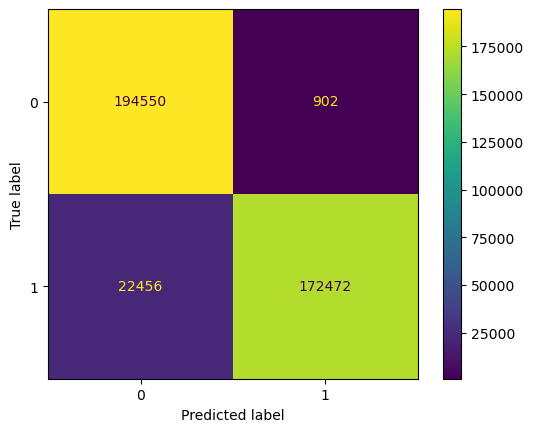

In [55]:
predictions = logreg1.predict(x_train)

print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

              precision    recall  f1-score   support

           0       0.67      0.69      0.68      7289
           1       0.68      0.67      0.67      7349

    accuracy                           0.68     14638
   macro avg       0.68      0.68      0.68     14638
weighted avg       0.68      0.68      0.68     14638



D:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


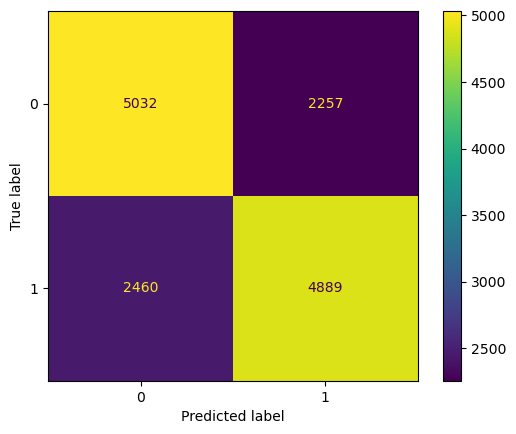

In [56]:
## with undersampling data

logreg2 = LogisticRegression()
logreg2.fit(x_train2, y_train2)
predictions2 = logreg2.predict(x_test2)

print(classification_report(y_test2, predictions2))
confusionmatrix(predictions2, y_test2)

              precision    recall  f1-score   support

           0       0.68      0.69      0.68     17107
           1       0.68      0.67      0.68     17047

    accuracy                           0.68     34154
   macro avg       0.68      0.68      0.68     34154
weighted avg       0.68      0.68      0.68     34154



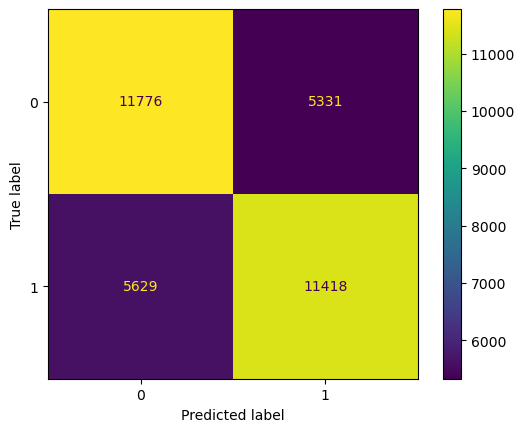

In [57]:
predictions = logreg2.predict(x_train2)

print(classification_report(y_train2, predictions))
confusionmatrix(predictions, y_train2)

## Train XGBoost Model

              precision    recall  f1-score   support

           0       0.92      1.00      0.95     83391
           1       0.99      0.91      0.95     83915

    accuracy                           0.95    167306
   macro avg       0.96      0.95      0.95    167306
weighted avg       0.96      0.95      0.95    167306



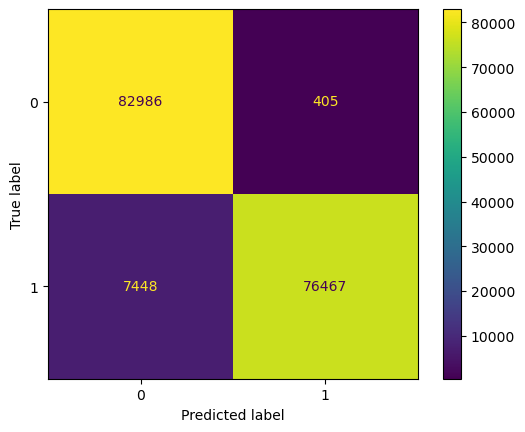

In [58]:
## with oversampling data

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train, y_train.ravel())

predictions = xgb_model.predict(x_test)
  
# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    195452
           1       1.00      0.91      0.95    194928

    accuracy                           0.96    390380
   macro avg       0.96      0.96      0.96    390380
weighted avg       0.96      0.96      0.96    390380



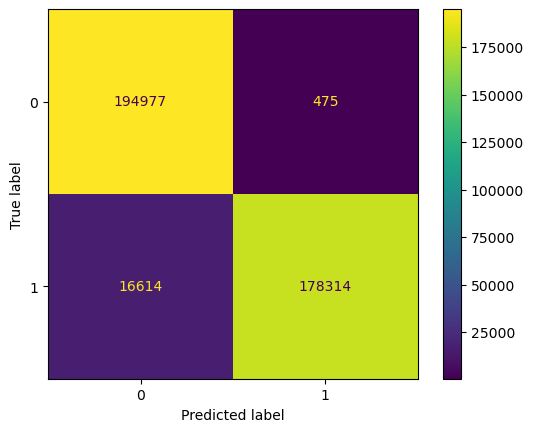

In [59]:
predictions = xgb_model.predict(x_train)
  
# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

## Random Forest

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     83391
           1       0.99      0.92      0.95     83915

    accuracy                           0.96    167306
   macro avg       0.96      0.96      0.96    167306
weighted avg       0.96      0.96      0.96    167306



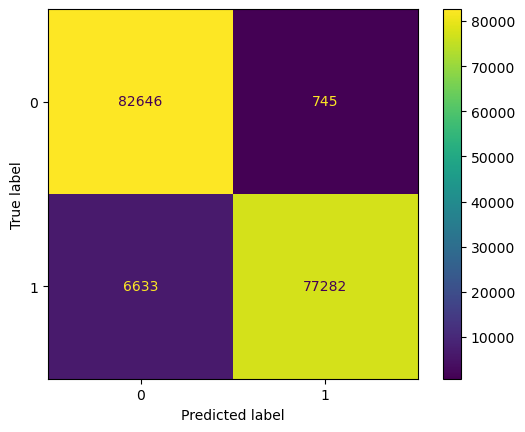

In [60]:
rf_model = RandomForestClassifier().fit(x_train, y_train)
predictions = rf_model.predict(x_test)
  
# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    195452
           1       1.00      1.00      1.00    194928

    accuracy                           1.00    390380
   macro avg       1.00      1.00      1.00    390380
weighted avg       1.00      1.00      1.00    390380



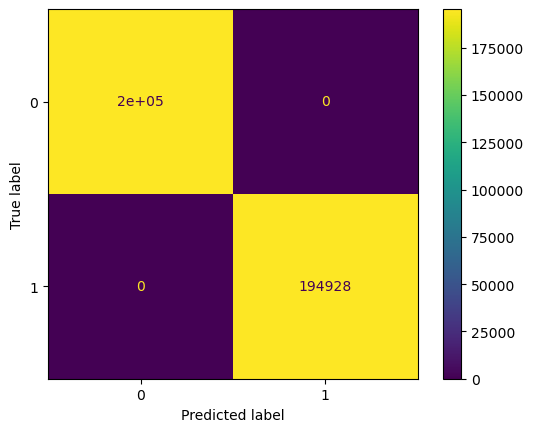

In [61]:
predictions = rf_model.predict(x_train)
  
# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

## Prediction

In [62]:
#import dataset

df_test = pd.read_csv(r'C:\Users\Wika Rabila Putri\Documents\Documents Lenovo\Rakamin\JAP\PBI September Home Credit Indonesia\Dataset HCI\application_test.csv')
df_test.sample(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
30010,318347,Cash loans,F,N,Y,0,225000.0,675000.0,80239.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
37109,371445,Cash loans,M,Y,Y,1,67500.0,76500.0,8779.5,76500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
4506,132216,Cash loans,M,Y,N,1,315000.0,450000.0,31320.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,10.0
37839,377045,Cash loans,M,Y,Y,0,202500.0,790830.0,44289.0,675000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
35993,363343,Cash loans,M,N,Y,0,99000.0,323014.5,15538.5,261000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
df_test['CODE_GENDER'] = df_test['CODE_GENDER'].replace(['XNA'], df_test['CODE_GENDER'].mode()[0])
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace(['XNA'], df_test['ORGANIZATION_TYPE'].mode()[0])

Marital_status = []
married = ['Married', 'Civil marriage']

for i in df_test.NAME_FAMILY_STATUS:
    if i in married:
        Marital_status.append('Married')
    else:
        Marital_status.append('Unmarried')

df_test['Marital_status'] = Marital_status
df_test.drop(columns= 'NAME_FAMILY_STATUS', inplace=True)

df_test['Age'] = np.floor(df_test['DAYS_BIRTH'] / -365).astype(int)
df_test.drop(columns= 'DAYS_BIRTH', inplace=True)

In [64]:
missing_values = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Data']).reset_index()
missing_values['Percentage'] = ( missing_values['Total Null Data'] / len(df) ) * 100
data_null = missing_values[missing_values['Percentage'] > 0].sort_values(by='Percentage', ascending=False)

In [65]:
a = list(data_null['index'])

for i in a:
    data = df_test[i]
    types = str(data.dtype)
    if types == 'object':
        df_test[i].fillna(df_test[i].mode()[0], inplace=True)
    else:
        df_test[i].fillna(df_test[i].median(), inplace=True)

In [66]:
num = df_test[num_a]

In [67]:
num = (num - num_mean) / num_std
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,-0.589198,-0.141492,-0.074799,-0.451269,-0.238934,-0.147217,-0.471630,-0.045538,1.444048,-0.131831,...,-0.588676,-0.275683,-0.938725,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.706463
1,-0.589198,-0.292491,-0.934414,-0.671615,-0.969925,1.077392,-0.486707,-1.164490,0.906640,-0.131831,...,-0.588676,-0.275683,1.164645,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,0.691001,0.456336
2,-0.589198,0.141631,0.159868,2.947791,0.248394,-0.129074,-0.486630,0.803313,-0.339140,-0.131831,...,-0.588676,-0.275683,0.129884,-0.07111,-0.058754,-0.155798,-0.270044,1.032087,1.257036,0.873213
3,2.528453,0.613502,2.424807,1.514138,2.806865,0.397937,-0.468368,0.852911,-0.806307,2.246432,...,-0.588676,-0.275683,-1.017299,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,0.691001,-0.460793
4,0.969627,0.047256,0.066055,0.343410,0.236211,-0.784603,-0.470658,0.286066,-0.842090,1.057301,...,-0.588676,-0.275683,0.172193,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,0.124965,-0.710920


In [68]:
num_1 = df_test[num_b]
num_1 = num_1.loc[~num_1.index.duplicated(keep='first')]

num = pd.concat([num, num_1], axis=1)
num

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
0,-0.589198,-0.141492,-0.074799,-0.451269,-0.238934,-0.147217,-0.471630,-0.045538,1.444048,-0.131831,...,0,1,0,1,0,0,0,0,0,0
1,-0.589198,-0.292491,-0.934414,-0.671615,-0.969925,1.077392,-0.486707,-1.164490,0.906640,-0.131831,...,0,1,0,0,0,0,0,0,0,0
2,-0.589198,0.141631,0.159868,2.947791,0.248394,-0.129074,-0.486630,0.803313,-0.339140,-0.131831,...,0,1,0,0,0,0,0,0,0,0
3,2.528453,0.613502,2.424807,1.514138,2.806865,0.397937,-0.468368,0.852911,-0.806307,2.246432,...,0,1,1,0,0,0,0,0,0,0
4,0.969627,0.047256,0.066055,0.343410,0.236211,-0.784603,-0.470658,0.286066,-0.842090,1.057301,...,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,-0.589198,-0.198116,-0.462932,-0.664467,-0.726261,-1.362140,-0.491639,-1.157688,-0.270224,-1.320962,...,1,1,1,0,0,0,0,0,0,0
48740,2.528453,-0.047118,0.058386,0.332532,-0.117102,1.077392,-0.463317,0.565238,-0.007815,2.246432,...,0,1,0,0,0,0,0,0,1,1
48741,0.969627,0.141631,-0.705290,0.422038,-0.604429,0.397937,-0.476618,0.659901,0.985495,1.057301,...,0,1,1,0,0,0,0,0,0,0
48742,-0.589198,0.236005,-0.369923,-0.135821,-0.238934,-0.147217,-0.474462,1.005676,1.078266,-0.131831,...,1,1,1,0,0,1,1,0,1,1


In [69]:
cat = df_test.select_dtypes(include='object')

cat_1 = cat.columns.tolist()  # One-Hot Encoding
cat_2 = ['column_name_1', 'column_name_2'] 

# One-hot encoding untuk kolom di cat_1
for cats in cat_1:
    onehots = pd.get_dummies(cat[cats], prefix=cats)
    cat = cat.join(onehots)

cat = cat.drop(columns=cat_1)

In [70]:
df_test = df_test.drop(columns=cat_1).join(cat)

cat_2 = [col for col in cat_2 if col in df_test.columns]

for cats in cat_2:
    df_test[cats] = label_enc.fit_transform(df_test[cats])

In [71]:
df_test

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,Marital_status_Married,Marital_status_Unmarried
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-2329,-5170.0,-812,...,False,False,False,False,True,False,True,False,True,False
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-4469,-9118.0,-1623,...,False,False,False,True,False,False,True,False,True,False
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-4458,-2175.0,-3503,...,False,False,False,True,False,False,True,False,True,False
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-1866,-2000.0,-4208,...,False,False,False,True,False,False,True,False,True,False
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-2191,-4000.0,-4262,...,False,False,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,0,121500.0,412560.0,17473.5,270000.0,0.002042,-5169,-9094.0,-3399,...,False,False,False,True,False,False,True,False,False,True
48740,456222,2,157500.0,622413.0,31909.5,495000.0,0.035792,-1149,-3015.0,-3003,...,False,False,False,True,False,False,True,False,True,False
48741,456223,1,202500.0,315000.0,33205.5,315000.0,0.026392,-3037,-2681.0,-1504,...,False,False,False,False,True,False,True,False,True,False
48742,456224,0,225000.0,450000.0,25128.0,450000.0,0.018850,-2731,-1461.0,-1364,...,False,False,False,True,False,False,True,False,True,False


In [72]:
df_test = pd.concat([num, cat], axis=1)

train = set(df.columns)
train.remove('TARGET')

not_in_test = list(train - set(df_test.columns))

missing_columns_df = pd.DataFrame(0, index=df_test.index, columns=not_in_test)
df_test = pd.concat([df_test, missing_columns_df], axis=1)

In [73]:
column_train = list(df.columns)
column_train.remove('TARGET')
df_test = df_test[column_train]

In [74]:
predictions = rf_model.predict(df_test)

In [75]:
df_test['TARGET'] = predictions

In [76]:
df_test['TARGET'].value_counts()

TARGET
0    45556
1     3188
Name: count, dtype: int64

## Summary

- The Home Credit Scorecard Model analysis identifies key customer segments for revolving loan contracts, focusing on individuals with income types such as business owners, maternity leave recipients, students, and unemployed individuals to tailor effective loan offerings.

- Recommendations include launching campaigns targeting accountants, the largest customer group with the best loan repayment rates, as well as creating targeted advertisements for HR professionals, IT specialists, and real estate agents to boost loan applications.

- Following a thorough evaluation, the Random Forest machine learning model is selected as the primary tool for predicting customer loan payment issues. This model demonstrates robust performance in identifying potential risks, enabling proactive management of possible loan defaults.